In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
pd.options.display.max_columns = None
%matplotlib inline

from venn import venn

In [2]:
mutect_df = pd.read_csv("../genomic_data/Raw_MuTect2_ALL.csv", sep="\t")
germline_df = pd.read_csv("../genomic_data/Raw_GATK_ALL.csv", sep="\t")
sv_df = pd.read_csv("../genomic_data/Raw_SV_ALL.csv", sep="\t").drop_duplicates()
type_list = {'MUTECT':mutect_df, 'Germline':germline_df, 'SV':sv_df}

In [3]:
samples = pd.read_csv("../../mortal_vs_immortal/SAMPLES/SAMPLES_Excel.tsv", sep="\t")

In [4]:
samples['label'] = samples.apply(lambda x: "T" if x['TMM'] == 'TEL' else "M"
                                 if (x['WestATRX'] == "Neg" or x['WestDAXX'] == "Neg") else "AP",
                                 axis=1)

In [5]:
gene_list = ['ATRX', 'DAXX', 'TP53']
sample_list = np.concatenate((samples['Immortal'].unique(), samples['Mortal'].unique()))
type_list = {'Somatic':mutect_df, 'Germline':germline_df, 'SV':sv_df}

In [6]:
mapping = dict(zip(samples['Immortal'].values, samples['label'].values))

In [7]:
combined_df_all = pd.concat([mutect_df, germline_df, sv_df])

In [8]:
impact = ['HIGH','MODERATE']

# P_ALT vs P_TEL vs P_LKO vs Mortal

In [9]:
df = combined_df_all[(combined_df_all['Name'].isin(
    ['JFCF_6_T_1_P_TEL', 'JFCF_6_T_1_P_ALT', 'JFCF_6_P_pLKO_5', 'JFCF_6']) &
                      (combined_df_all['Impact'].isin(impact)) &
                      (combined_df_all['Source'] != 'MuTect2'))].sort_values(
                          by=['Key', 'Name'])

In [10]:
df['Key'] = df['Key'].str.replace('_Immortal', '')
df['Key'] = df['Key'].str.replace('_Somatic', '')
df['Key'] = df['Key'].str.replace('_Mortal', '')
df = df.drop_duplicates(subset=df.columns.values[df.columns.values!='Consequence'])
df = df.drop_duplicates(subset=['Key', 'Name'])

In [11]:
df.groupby(['Name']).size()

Name
JFCF_6              21555
JFCF_6_P_pLKO_5     18164
JFCF_6_T_1_P_ALT    17448
JFCF_6_T_1_P_TEL    17953
dtype: int64

In [12]:
df[df['Gene']=='ATRX']

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
59422,SNP_GATK_HIGH_ATRX_chrX_76891525_G_T,JFCF_6_P_pLKO_5,GATK,False,SNP,chrX,76891525,NaN,NaN,794.88,NaN,0.5,NaN,"[2, 23]",NaN,ATRX,stop_gained,HIGH,G,T,NaN,NaN
52985,SNP_GATK_HIGH_ATRX_chrX_76938581_C_A,JFCF_6_T_1_P_ALT,GATK,False,SNP,chrX,76938581,NaN,NaN,322.77,NaN,0.5,NaN,"[4, 9]",NaN,ATRX,stop_gained,HIGH,C,A,NaN,NaN


In [13]:
p_alt = df[(
    (df['Name'] == 'JFCF_6_T_1_P_ALT') &
    (df['Impact'].isin(impact)))].sort_values(by=['Key', 'Name'])
p_tel = df[(
    (df['Name'] == 'JFCF_6_T_1_P_TEL') &
    (df['Impact'].isin(impact)))].sort_values(by=['Key', 'Name'])
p_plko = df[(
    (df['Name'] == 'JFCF_6_P_pLKO_5') &
    (df['Impact'].isin(impact)))].sort_values(by=['Key', 'Name'])
mortal = df[(
    (df['Name'] == 'JFCF_6') &
    (df['Impact'].isin(impact)))].sort_values(by=['Key', 'Name'])

In [14]:
mutations = {
    'p_alt': set(p_alt['Key']),
    'p_tel': set(p_tel['Key']),
    'p_plko': set(p_plko['Key']),
    'mortal': set(mortal['Key'])
}

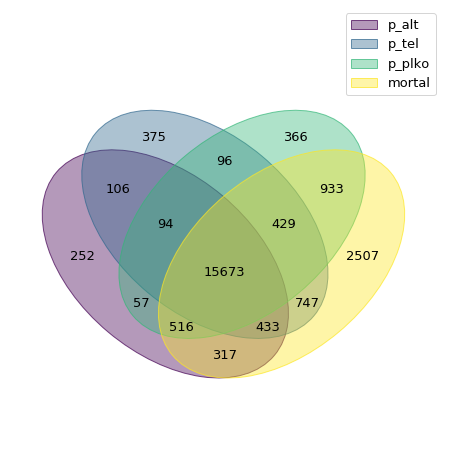

In [15]:
venn(mutations)

In [16]:
res = pd.DataFrame({'Key':df['Key'].unique()})

res['in_p_alt'] = res['Key'].map(lambda x:True if x in p_alt['Key'].values else False)
res['in_p_tel'] = res['Key'].map(lambda x:True if x in p_tel['Key'].values else False)
res['in_p_plko'] = res['Key'].map(lambda x:True if x in p_plko['Key'].values else False)
res['in_mortal'] = res['Key'].map(lambda x:True if x in mortal['Key'].values else False)

key_gene = df.groupby(['Key','Gene','Consequence']).size().reset_index().drop([0], axis=1)

key_gene = key_gene.drop_duplicates("Key", keep='first')

res = pd.merge(res, key_gene, on=['Key'])

res = res.sort_values(by=['Gene'])

In [17]:
res.head()

,Key,in_p_alt,in_p_tel,in_p_plko,in_mortal,Gene,Consequence
2151,SNP_GATK_MODERATE_A1BG_chr19_58864479_T_C,True,True,True,True,A1BG,missense_variant
2156,SNP_GATK_MODERATE_A2M_chr12_9232268_T_C,True,True,True,True,A2M,missense_variant
2157,SNP_GATK_MODERATE_A2M_chr12_9248233_T_C,True,True,True,True,A2M,missense_variant
2155,SNP_GATK_MODERATE_A2ML1_chr12_9020489_A_G,True,True,True,True,A2ML1,missense_variant
2154,SNP_GATK_MODERATE_A2ML1_chr12_9016573_A_G,True,True,True,True,A2ML1,missense_variant


In [18]:
res.to_csv("../results/palt_ptel_plko_mutations.tsv", index=False, sep='\t')

In [19]:
df.to_csv("../results/palt_ptel_plko_mutations_details.tsv", index=False, sep='\t')

# J Cell Lines

In [20]:
df = combined_df_all[(combined_df_all['Name'].isin([
    'JFCF_6_T_1J_11C', 'JFCF_6_T_1J_6B', 'JFCF_6_T_1J_11E', 'JFCF_6_T_1J_1_3C',
    'JFCF_6'
]) & (combined_df_all['Impact'].isin(impact)) &
                      (combined_df_all['Source'] != 'MuTect2'))].sort_values(
                          by=['Key', 'Name'])

In [21]:
df['Key'] = df['Key'].str.replace('_Immortal', '')
df['Key'] = df['Key'].str.replace('_Somatic', '')
df['Key'] = df['Key'].str.replace('_Mortal', '')
df = df.drop_duplicates(subset=df.columns.values[df.columns.values!='Consequence'])

In [22]:
df.groupby(['Name']).size()

Name
JFCF_6              69285
JFCF_6_T_1J_11C     17577
JFCF_6_T_1J_11E     17529
JFCF_6_T_1J_1_3C    17693
JFCF_6_T_1J_6B      17739
dtype: int64

In [23]:
alt_11E = df[(
    (df['Name'] == 'JFCF_6_T_1J_11E') &
    (df['Impact'].isin(impact)))].sort_values(by=['Key', 'Name'])
alt_3C = df[(
    (df['Name'] == 'JFCF_6_T_1J_1_3C') &
    (df['Impact'].isin(impact)))].sort_values(by=['Key', 'Name'])
tel_11C = df[(
    (df['Name'] == 'JFCF_6_T_1J_11C') &
    (df['Impact'].isin(impact)))].sort_values(by=['Key', 'Name'])
tel_6B = df[(
    (df['Name'] == 'JFCF_6_T_1J_6B') &
    (df['Impact'].isin(impact)))].sort_values(by=['Key', 'Name'])
mortal = df[(
    (df['Name'] == 'JFCF_6') &
    (df['Impact'].isin(impact)))].sort_values(by=['Key', 'Name'])

In [24]:
mutations = {
    'alt_1J_11E': set(alt_11E['Key']),
    'alt_1J_1_3C': set(alt_3C['Key']),
    'tel_1J_11C': set(tel_11C['Key']),
    'tel_1J_6B': set(tel_6B['Key']),
    'mortal': set(mortal['Key'])
}

Text(0.5, 1.0, 'J cell lines Distinct Mutations')

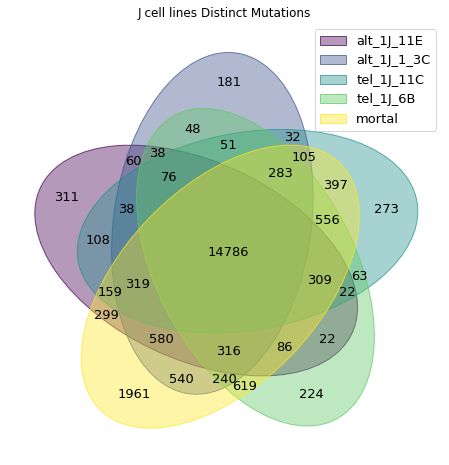

In [25]:
venn(mutations)
plt.title("J cell lines Distinct Mutations")

Text(0.5, 1.0, 'J cell lines Mutated Genes')

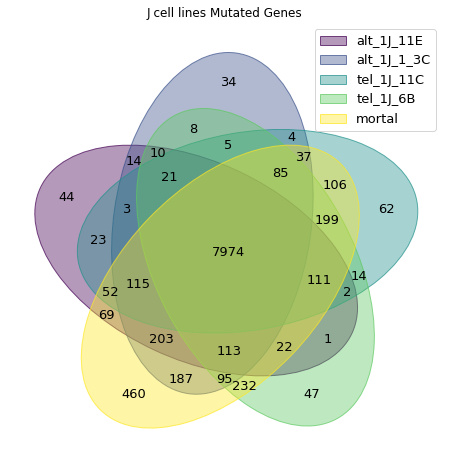

In [26]:
mutations_genes = {
    'alt_1J_11E': set(alt_11E['Gene']),
    'alt_1J_1_3C': set(alt_3C['Gene']),
    'tel_1J_11C': set(tel_11C['Gene']),
    'tel_1J_6B': set(tel_6B['Gene']),
    'mortal': set(mortal['Gene'])
}
venn(mutations_genes)
plt.title("J cell lines Mutated Genes")

In [27]:
mutations_no_mortal = {}
mutations_no_mortal['alt_1J_11E'] = set(alt_11E['Key']) - set(mortal['Key'])
mutations_no_mortal['alt_1J_1_3C'] = set(alt_3C['Key']) - set(mortal['Key'])
mutations_no_mortal['tel_1J_11C'] = set(tel_11C['Key']) - set(mortal['Key'])
mutations_no_mortal['tel_1J_6B'] = set(tel_6B['Key']) - set(mortal['Key'])

Text(0.5, 1.0, 'J cell lines Distinct Mutations (minus Mortal)')

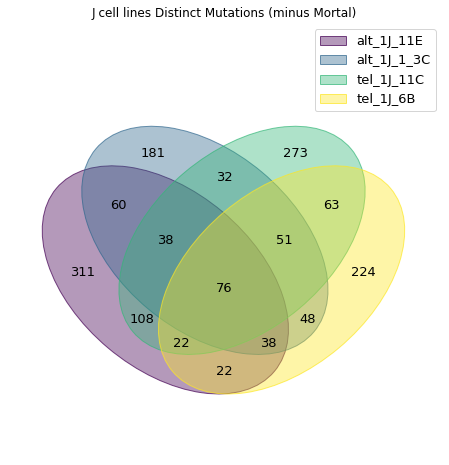

In [28]:
venn(mutations_no_mortal)
plt.title("J cell lines Distinct Mutations (minus Mortal)")

Text(0.5, 1.0, 'J cell lines Mutated Genes (minus Mortal)')

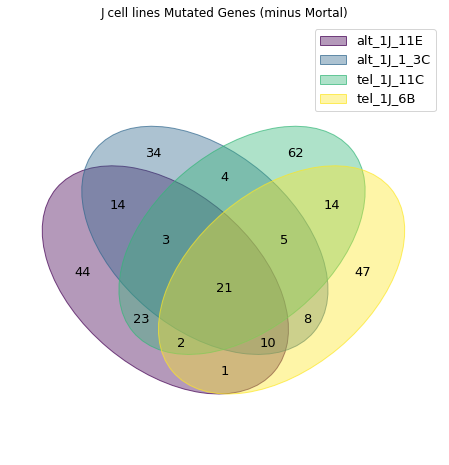

In [29]:
mutations_no_mortal_genes = {}
mutations_no_mortal_genes['alt_1J_11E'] = set(alt_11E['Gene']) - set(mortal['Gene'])
mutations_no_mortal_genes['alt_1J_1_3C'] = set(alt_3C['Gene']) - set(mortal['Gene'])
mutations_no_mortal_genes['tel_1J_11C'] = set(tel_11C['Gene']) - set(mortal['Gene'])
mutations_no_mortal_genes['tel_1J_6B'] = set(tel_6B['Gene']) - set(mortal['Gene'])
venn(mutations_no_mortal_genes)
plt.title("J cell lines Mutated Genes (minus Mortal)")

In [30]:
alt_11E[alt_11E['Gene']=='ATRX']

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
367074,SV_GRIDSS_HIGH_ATRX_chrX_76853017_76853018_chr...,JFCF_6_T_1J_11E,GRIDSS,False,Deletion,chrX,76853017-76853018,chrX,77014863-77014864,NotSplit:239.32;Split:302.85,NotSplit:239.32;Split:302.85,NaN,NaN,NotSplit:13;Split:12,NotSplit:13;Split:12,ATRX,gene_fusion&frameshift_variant,HIGH,A,A[CHRX:77014864[,A,]CHRX:76853018]A


In [31]:
alt_3C[alt_3C['Gene']=='ATRX']

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
383255,SV_GRIDSS_HIGH_ATRX_chrX_76853017_76853018_chr...,JFCF_6_T_1J_1_3C,GRIDSS,False,Deletion,chrX,76853017-76853018,chrX,77014863-77014864,NotSplit:343.72;Split:285.82,NotSplit:343.72;Split:285.82,NaN,NaN,NotSplit:19;Split:11,NotSplit:19;Split:11,ATRX,gene_fusion&frameshift_variant,HIGH,A,A[CHRX:77014864[,A,]CHRX:76853018]A


In [32]:
res = pd.DataFrame({'Key':df['Key'].unique()})
for key, value in mutations.items():
    res[key] = res['Key'].map(lambda x:True if x in value else False)


In [33]:
key_gene = df.groupby(['Key','Gene','Consequence']).size().reset_index().drop([0], axis=1)

key_gene = key_gene.drop_duplicates("Key", keep='first')

res = pd.merge(res, key_gene, on=['Key'])

res = res.sort_values(by=['Gene','Key'])

In [34]:
res.to_csv("../results/mutations_J_celllines.tsv", index=False, sep="\t")

In [35]:
res['Key'][0]

'IND_GATK_HIGH_AAMDC_chr11_77629132_A_AT'